In [71]:
import pandas as pd
import bs4
import re

def extract_data_from_html(html_file):
    # Open the HTML file and read its contents
    with open(html_file, 'r', encoding='utf-8') as file:
        html_content = file.read()

    # Parse the HTML content
    soup = bs4.BeautifulSoup(html_content, 'html.parser')
    
        
    ## Try to find the country name in various potential formats
    #country_name = soup.find('p', class_=re.compile(r'^s[0-9]+'))
    #if country_name:
    #    country_name = country_name.get_text(strip=True)
    #else:
    #    country_name = "Country not found"
    
    # Extract styles and find the first occurrence of a large font size
    styles = soup.find('style')
    country_name = "Country style not found"
    large_font_size = 30
    selected_style = None
    if styles:
        # This regex matches any style definitions with font-size in pt
        matches = re.findall(r'(\.?[\w]+)\s*{\s*[^}]*font-size:\s*(\d+)pt', styles.get_text())
        # Find the first style with font-size > 20pt
        for style, size in matches:
            if int(size) > large_font_size:
                selected_style = style
                break

        if selected_style:
            if selected_style.startswith('.'):  # It's a class
                style_class = selected_style.strip('.')
                country_tags = soup.find_all(class_=style_class)
                country_name = country_tags[0].get_text(strip=True)
            else:  # It's a tag like 'p'
                country_tags = soup.find_all(selected_style)
                # select the first tag without a style attribute like s<number> 
                for tag in country_tags:
                    if not tag.has_attr('style'):
                        country_name = tag.get_text(strip=True)
                        break
                
                
    
    # Extract data for "Land area below 5m (% of land area)"
    land_area = soup.find(string=re.compile(r'Land area below 5m \(.*?\)'))
    if land_area and land_area.find_next():
        land_area_value = land_area.find_next().get_text(strip=True)
    else:
        land_area_value = "Data not found"
    
    # Extract data for "Population below 5m (% of total)"
    population = soup.find(string=re.compile(r'Population below 5m \(.*?\)'))
    if population and population.find_next():
        population_value = population.find_next().get_text(strip=True)
    else:
        population_value = "Data not found"

    return country_name, land_area_value, population_value

# Example usage
html_file_path = 'pages/page_112.html'
data = extract_data_from_html(html_file_path)
print(f"Country: {data[0]}, Land Area Below 5m: {data[1]}, Population Below 5m: {data[2]}")




Country: Country style not found, Land Area Below 5m: 0.4, Population Below 5m: 3.3


In [66]:
# Loop through HTML files in the pages directory
data_list = []
html_files = [file for file in os.listdir('pages') if file.endswith('.html')]
for html_file in html_files:
    html_file_path = os.path.join('pages', html_file)
    data = extract_data_from_html(html_file_path)
    #print(f"Country: {data[0]}, Land Area Below 5m: {data[1]}, Population Below 5m: {data[2]} file: {html_file}")
    # if country name data[0] starts with 'Country' or 'Population', then print
    if data[0].startswith('Country') or data[0].startswith('Population'):
        print(f"Country not found in file: {html_file}")
    
    data_list.append(data)

# Create a DataFrame
df = pd.DataFrame(data_list, columns=['Country', 'Land Area Below 5m', 'Population Below 5m'])
# convert the values to numeric unless they are '..' if latter convert to NaN
df['Land Area Below 5m'] = pd.to_numeric(df['Land Area Below 5m'], errors='coerce')
df['Population Below 5m'] = pd.to_numeric(df['Population Below 5m'], errors='coerce')
# Save DataFrame to an Excel file
df.to_excel('countries_pop_land_below_5m.xlsx', index=False)

Country not found in file: page_112.html
Country not found in file: page_113.html
Country not found in file: page_126.html
Country not found in file: page_152.html
Country not found in file: page_164.html
Country not found in file: page_172.html
Country not found in file: page_178.html
Country not found in file: page_204.html
Country not found in file: page_30.html
Country not found in file: page_46.html
Country not found in file: page_6.html
Country not found in file: page_92.html


PermissionError: [Errno 13] Permission denied: 'countries_pop_land_below_5m.xlsx'

In [58]:
df

,Country,Land Area Below 5m,Population Below 5m
0,Afghanistan,0.0,0.0
1,Aruba,29.6,29.6
2,Kazakhstan,6.7,3.9
3,Kenya,0.2,1.4
4,Kiribati,96.7,95.2
...,...,...,...
213,Israel,7.8,8.3
214,Italy,5.2,7.5
215,Jamaica,7.1,5.8
216,Japan,5.9,16.2


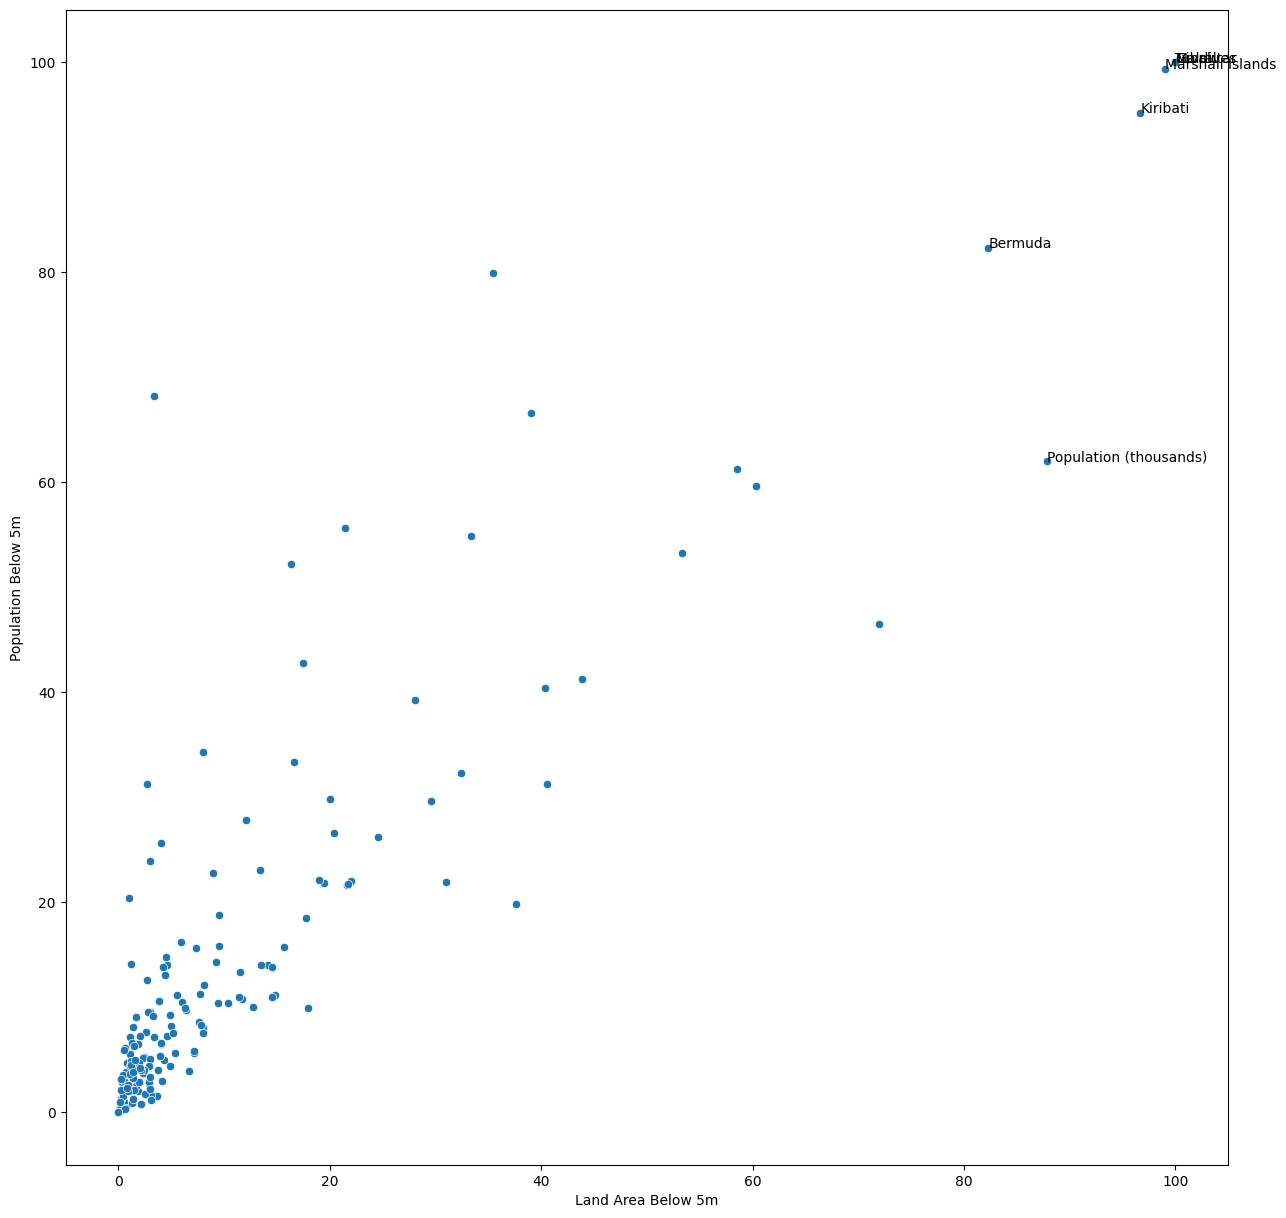

In [63]:
# plot df to see the data using sns scatter plot
import seaborn as sns
# set plot size to 15, 15
plt.figure(figsize=(15, 15))
import matplotlib.pyplot as plt
# drop rows with missing values for land area and population
df = df.dropna(subset=['Land Area Below 5m', 'Population Below 5m'])
sns.scatterplot(data=df, x='Land Area Below 5m', y='Population Below 5m')
# label points with country names
for row in df.itertuples():
    # if at least one is > 80, label the point
    if row[2] > 80 or row[3] > 80:
        plt.text(row[2], row[3], row[1])
plt.show()